<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

> TODO: Intro

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image, Math
import gif
import numpy as np
import pandas as pd
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os
from fractions import Fraction

# Functions created in 04 tutorial

from libs.helper_05_tutorial import *

def prettify_states(states, mm_list=None):
    pretty_states = np.zeros([states[0].shape[0],len(states)], dtype="object")
    
    for j, state in enumerate(states):
        x = []
        for i, val in enumerate(state):
            pretty_states[i,j] = f"{val[0,0]:.1f}"
    if (mm_list == None):
        df = pd.DataFrame(data=pretty_states)
    else:
        df = pd.DataFrame(data=pretty_states, index=mm_list)
            
    return df

## The states of 2 TSS

As soon as we start adding more than one TSS things get quite complicated. In order to give us an intuition for how such systems behave, we will take a small step back and remove the quantised field (don't worry, we'll bring it back in the next tutorial).


Let's start simple and look at 2 TSS. We can describe this system by the different possible combinations of the higher (+) and lower (-) energy states of the individual TSS namely:
- |+,+>
- |+,->
- |-,+>
- |-,->

We can see that 2 TSS is actually a 4 state system. Mathematically these 4 states can be represented as vectors of length 4 using the following basis:

$$
|+, +> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|+, -> = \begin{bmatrix}
 0   \\
 1   \\
 0   \\
 0   \\
\end{bmatrix}, 
|-, +> = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 0   \\
\end{bmatrix}, 
|-, -> = \begin{bmatrix}
 0   \\
 0   \\
 0   \\
 1   \\
\end{bmatrix}
$$

How do we create these states in QuTiP?

In [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) we learnt to describe such states by using the tensor product. For example, we would create the |+,-> state by doing:

In [2]:
pm = tensor(basis(2,0), basis(2,1))
pm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

and we can keep track of which basis states corresponds to which row of the vector by using the `product` function that we introduced in the previous tutorial. Specifically:

In [3]:
possible_ms = ["+","-"]
mm_list = [m for m in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

So, the row number 1 of the state vector refers to the basis state:

In [4]:
mm_list[1]

('+', '-')

How does such a system behave?

## TSS Recap

We have previously looked at a TSS whose states are allowed to couple to each other with strength $A$. This coupling resulted in a splitting of the states of constant energy. When we perturbed the energy of those states by an amount $\pm \delta$ we found (in [tutorial 02](https://github.com/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb)) that a natural way to represent the Hamiltonian is

$$
H = \begin{bmatrix}
 A  &  \delta  \\
 \delta  &  -A  \\
\end{bmatrix} = A\sigma_z +\delta \sigma_x
$$

The base states being used to represent this system are the stationary states of the unperturbed system ($\delta=0$) that we describe by:

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-> = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$

where |+>, |-> correspond to the higher and lower energy states respectively. 

You may recall that there are mathematical similarities between a TSS and a spin $1/2$ particle. When considering many TSS, we will find it invaluable to refer to well known spin results, such as conservation of angular momentum, to help us solve problems. In light of this, we will introduce a factor of $1/2$ into the Hamiltonian:

$$
H = \frac{1}{2}A\sigma_z +\frac{1}{2}\delta \sigma_x
$$

so that we can rewrite the Hamiltonian in terms of spin operators, (denoted by $S$), for a [spin $1/2$ particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables), i.e.

$$
H = A S_{z} + \delta S_{x}
$$


## Describing independent TSS


A natural starting point for the Hamiltonian of $N$ independent TSS each interacting with a perturbing "field" of strength $\delta$ is:

$$
H = A \overset{N}{\underset{n=1}{\Sigma}} S_{n z} +  \delta \overset{N}{\underset{n=1}{\Sigma}} S_{n x} 
$$

Because spin represents angular momentum, the sum of $N$ spin operators above is mathematically the same as how one would create the [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) - denoted by $J$, e.g. $J_x = \overset{N}{\underset{n=1}{\Sigma}} S_{n x}$. The Hamiltonian can then be written more compactly as:

$$
H = A J_{z} +  \delta J_{x}
$$


QuTiP has a nice function, [`jspin`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.jspin),  to generate the $J$ operators for any given number of TSS (note, you must import [`qutip.piqs`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.piqs) to use this)

In [5]:
J = jspin(2, basis="uncoupled")

Let's see how the $J_z$ operator acts on the |+,-> state we created earlier.

In [6]:
J[2]*pm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

We get zero because $J_z$ is in essence creating a running total of the number of "spin ups" (+)  minus the "spin downs" (-). For |+, -> we have 1 up and 1 down and so we get zero.



We proceed as we have done several times by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.

To find the states of constant energy, we'll follow what we did in Tutorial 2. Specifically, we will calculate the eigenvalues and eigenvectors of the Hamiltonian and see how they depend on the the perturbation strength $\delta$.

Let's see what we find.

## Stationary states

In [7]:
num_deltas = 100

In [13]:
df = make_df_for_energy_scan("$\delta$/A", -4,4, num_deltas, J[0].shape[0]) 

In [14]:
vec = np.zeros([J[0].shape[0], J[0].shape[0],num_deltas])

In [15]:
A=0.1

In [20]:
for i, row in df.iterrows():
    H = A*J[2] + row[ "$\delta$/A"]*A*J[0]
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals
    for j, ket in enumerate(ekets):
        ket = np.transpose(ket)
        vec[j,:,i] = np.abs(ket*np.conj(ket))

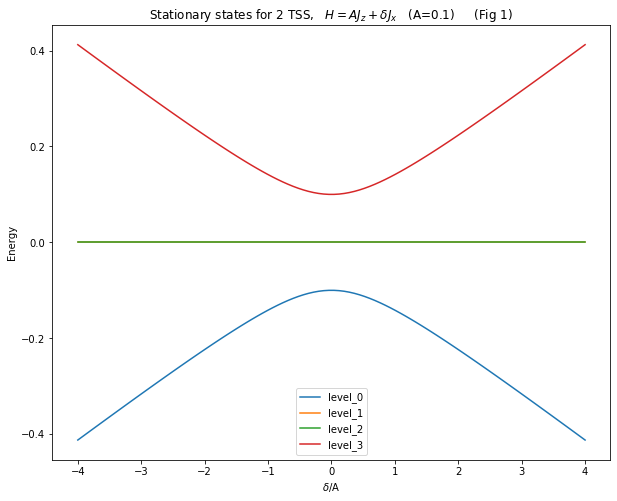

In [21]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 1)");
plt.ylabel("Energy");

Superficially, Fig 1 resembles Fig 3 of [Tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.1-Static-perturbation) in that we see an avoided crossing when there is no perturbation. 

What is most interesting is that there are 2 levels with the same energy (aka [degenerate](https://en.wikipedia.org/wiki/Degenerate_energy_levels) levels) whose value does not show any dependence on $\delta$. Let's explore what the eigenstates look like as we change $\delta$.

In [25]:
# Create the bra and ket labels for making nice labels for plots
bra_labels, ket_labels = make_braket_labels(mm_list)

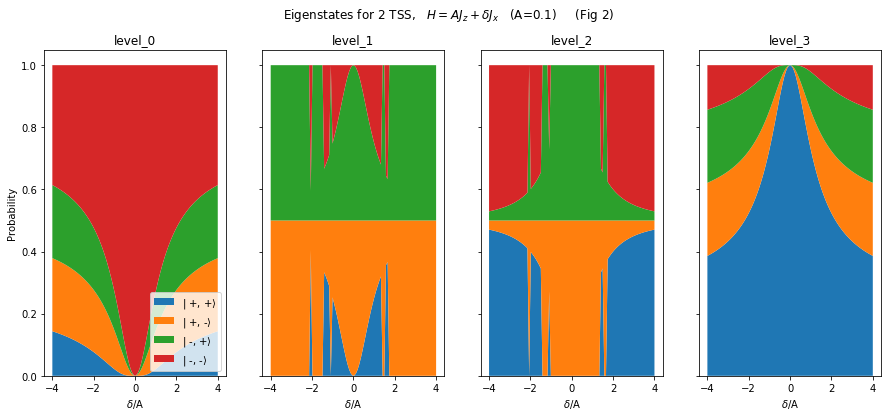

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

for i in range(0,vec.shape[0]):
    axes[i].stackplot(df[ "$\delta$/A"], vec[i,:,:], labels=ket_labels);
    axes[i].set_xlabel("$\delta$/A")
    axes[i].set_title(f"level_{i}")
axes[0].set_ylabel("Probability")
axes[0].legend(loc='lower right')

fig.suptitle('Eigenstates for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 2)');

Fig 2 shows us how much of each basis state makes up each eigenstate (which corresponds to a particular energy level) as we change $\delta$. For example, level_0 with $\delta/A = -0.4$, is made up of roughly:
- 40% |-,-> (red)
- 20% |-,+> (green)
- 25% |+,-> (orange)
- 15% |+,+> (blue).


We expect the eigenstates to change in a smooth way as we change $\delta$, but we can see that level_1 and level_2 show some spiky behaviour. This is due to the degenerate nature of the energy levels and the numerical methods used by QuTiP - the eigenstates can sometimes swap their order in the numpy array. We can fix this manually in the following way:

In [29]:
# Looks at level 1 and finds the places where the state |+,+> (blue) has a non zero value i.e. the spiky points
ind = vec[1,0,:] > 0 

# swaps the eigenstates of level_1 and level_2 only at the spiky places
vec[1,:,ind], vec[2,:,ind] = vec[2,:,ind], vec[1,:,ind]

Now let's replot 

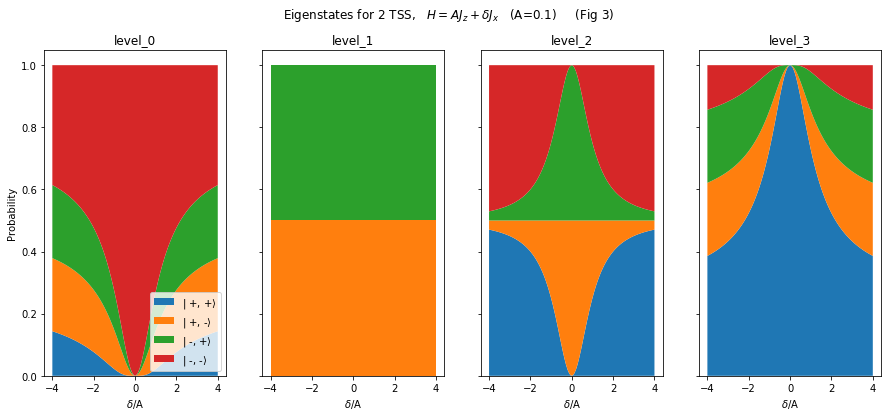

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

for i in range(0,vec.shape[0]):
    axes[i].stackplot(df[ "$\delta$/A"], vec[i,:,:], labels=ket_labels);
    axes[i].set_xlabel("$\delta$/A")
    axes[i].set_title(f"level_{i}")
axes[0].set_ylabel("Probability")
axes[0].legend(loc='lower right')

fig.suptitle('Eigenstates for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 3)');

Much better. There is a lot to say about Fig 3:
1. As $\delta \rightarrow 0$, level_0 and level_3 behave as one would expect, namely the eigenstate corresponding to lowest energy level_0 becomes |-,->, and for the highest energy level_3 it's |+,+>
2. The eigenstate corresponding to level_1 has no dependency on the perturbation $\delta$
3. As $\delta \rightarrow 0$, the level_2 eigenstate approaches the same as level_1 (within a phase factor)

In order to solve the mystery of the indifference of level_1 to $\delta$, we need to first understand another puzzle. Let's look at the numerical values of the eigenstates for a very small $\delta=0.001$.

In [31]:
delta = 0.001
H = A*J[2] + delta*J[0]
evals, ekets = H.eigenstates()

In [33]:
# We created a function to make states nicer to look at (see top of notebook)
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",-0.0+0.0j,-0.7+0.0j,-0.7+0.0j,0.0+0.0j
"(-, +)",-0.0+0.0j,-0.7+0.0j,0.7+0.0j,0.0+0.0j
"(-, -)",1.0+0.0j,-0.0+0.0j,0.0+0.0j,0.0+0.0j


We can see that levels 1 and 2 are "in phase" and "out of phase" mixtures of |+,-> and |-,+>. This kind of combination of basis states is often referred to as an [entangled state](https://en.wikipedia.org/wiki/Quantum_entanglement#Pure_states).

When we compare this to the unperturbed case, i.e. $\delta=0$, we see a large difference:

In [34]:
H0 =  A*J[2]
evals0, ekets0 = H0.eigenstates()

In [35]:
prettify_states(ekets0, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(-, +)",0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j
"(-, -)",1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


The reason for the discontinuity in the eigenstates for $\delta \ll 1$ vs $\delta=0$ is because both basis states are equally valid ways to represent the states of constant energy.

However, there is clearly something important to understand about the basis made up of entangled states - even when we have a tiny perturbation this is the apparently the appropriate basis for describing the stationary states.

What makes the entangled basis special? It has to do with angular momentum.

## Angular momentum

Although we are not dealing explicitly with the physics of spin angular momentum, we are using the same mathematics. For example, we are already using the x and z "components" of the total angular momentum operator $J_x$ and $J_z$. What can we learn from other operators, e.g. what about the "magnitude" of the total angular momentum operator? 

I use quote marks around "component" and "magnitude" because this is vector language which is not obviously applicable to operators. It turns out, however, that we can treat the angular momentum operator as a vector in some sense (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions)). We can create the squared magnitude of the total angular momentum operator ($J^2$) much like we would a vector - we sum of the squares of the components.

In [38]:
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

What does this operator tell us?

Just as we learnt about states of constant energy by calculating the eigenvalues and eigenvectors of the Hamiltonian, we can learn about states of constant angular momentum by calculating the eigenvalues and eigenvectors of $J^2$.


In [39]:
evalsJ, eketsJ = J2.eigenstates()

In [40]:
evalsJ

array([1.11022302e-15, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00])

Although not immediately obvious, the eigenvalues of $J^2$ always have the form $j(j+1)$, where $j$ is a number that characterises the angular momentum of the system with $2j$ being an integer. Therefore, even without explicitly looking at the eigenstates of $J^2$, we know they must correspond to:
- j=0 - one state
- j=1 - three states

But, where do these $j$ numbers come from, and what does it mean to have many states with the same value of $j$?


In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$.

So, although we still haven't explicitly looked the 4 eigenstates of $J^2$, we can say that the eigenstates can be uniquely described by 2 numbers $|j, m \rangle$, namely:

- $|0, 0 \rangle$
- $|1, -1 \rangle$
- $|1, 0 \rangle$
- $|1, 1 \rangle$

The specific $j$ and $m$ numbers come from adding up the angular momentum for many single TSS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TSS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$

e.g.

In [41]:
j_vals(2)

array([0., 1.])

In [42]:
m_vals(1)

array([-1,  0,  1])

Let's now take a look at the eigenstates in the |±, ±> basis and see if we can match them to the corresponding $|j, m \rangle$ that we've just motivated.

In [43]:
prettify_states(eketsJ, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(+, -)",0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, +)",-0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, -)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j


Keeping in mind that ± corresponds to $m= ±1/2$ we have:

- $\mathbf{0} = 0.7|+, - \rangle - 0.7|-, + \rangle = |0, 0 \rangle$ ($m=0$ because + and - cancel out, $j=0$ because of anti-parallel addition of states)
- $\mathbf{1} = \ \ \ \ \  |+,+ \rangle \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = |1, 1 \rangle$ 
- $\mathbf{2} = 0.7|+, - \rangle + 0.7|-, + \rangle = |1, 0 \rangle$ ($m=0$ because + and - cancel out, $j=1$ because of parallel addition of states)
- $\mathbf{3} =  \ \ \ \ \  |-,- \rangle \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = |1, -1 \rangle$ 

You might have also noticed that these eigenstates are identical to the mysterious entangled basis states that we encountered earlier. This implication is that we might do a better job of describing many TSS interacting with some field by working in a basis corresponding to states of constant "angular momentum".

Let's have a go and running a simulation using this basis (often called the [Dicke basis](https://journals.aps.org/pr/pdf/10.1103/PhysRev.93.99) - see also [here](http://dx.doi.org/10.1002/qute.201800043)) and see what we find.

## Simulation in the Dicke basis

We've already found the stationary states for a static perturbation. Let's proceed as we did in [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.2-Time-dependent-perturbation) and introduce a resonant time dependent perturbation. Specifically, the Hamiltonian will be:

$$
H = A J_{z} + \delta J_{x} \cos(\omega t)
$$

with $\omega = A$.

The idea is to start the system off in a stationary state of the unperturbed ($\delta=0$) system and then see what happens when we make $\delta= 0.001$. When the system depends explicitly on time, the energy in not conserved and so the system will evolve away from where it started.  Although $\delta$ is small, we know from our previous experience in tutorial 2 that because the time-dependence is resonant, we can expect the changes in time to be significant.

QuTiP has an easy way for us to create $J$ operators in the Dicke basis . We have used it already [`jspin`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.jspin) - this time we won't need to use the "basis" parameter.

In [44]:
J = jspin(2)

In this Dicke basis, the states are odered from high to low in $|j, m\rangle$. We can therefore write the ordered list of states `jm_list` as:

In [46]:
jm_list = []
js = j_vals(2)[::-1]
for j in js:
    ms = m_vals(j)[::-1]
    for m in ms:
        jm_list.append((j,m))      
print(jm_list)

[(1.0, 1.0), (1.0, 0.0), (1.0, -1.0), (0.0, -0.0)]


Because we have a time dependent Hamiltonian, we need to use QuTiP's ["string based method"](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#string-format-method) to evolve the system (as we did in tutorial 2).

In [53]:
delta = 0.001
A = 0.1

H0 = A*J[2]  # Unperturbed system

H1 =  delta*J[0] # Perturbation

H_list = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

evals, ekets = H0.eigenstates()  # Find stationary states of unperturbed system

psi0 = ekets[3] # Start the system in the highest energy state i.e. level_3

result = sesolve(H_list, psi0, times, args={'w':A})

As in tutorials 1 and 2, we need to do some post processing of the results of `sesolve` in order to calculate the probabilities from the state vector and also make things easier to plot.

In addition, we need to transform the state vector into the basis consisting of stationary states of $H_0$ in order to see how the system is moving from one energy state to another.

We'll create a function for this so that we might re-use it.

In [54]:
def make_p_psi_arrays(states, basis=None):
    
    # Create empty numpy arrays to hold psi and P
    num_states = states[0].shape[0]
    num_psi = len(states)
    psi = np.zeros([num_psi, num_states], dtype="complex128")
    P = np.zeros([num_psi, num_states])
    
    # If we add a list of basis states then psi will be transformed into that state before the
    # probabilities are calculated
    if basis is None:
        for i, state in enumerate(states):
            psi[i,:] = np.transpose(state)
            P[i,:] = np.abs(psi[i,:]*np.conj(psi[i,:]))
    else:
        for i, state in enumerate(states):
            transformed_state = state.transform(basis)
            psi[i,:] = np.transpose(transformed_state)
            P[i,:] = np.abs(psi[i,:]*np.conj(psi[i,:]))

    return  psi, P
        

In [55]:
psi, P = make_p_psi_arrays(result.states, ekets) # ekets are the stationary states of H_0

Let's put the probability array inside a dataframe to make it easier to plot.

In [56]:
df = pd.DataFrame(P, index=times)

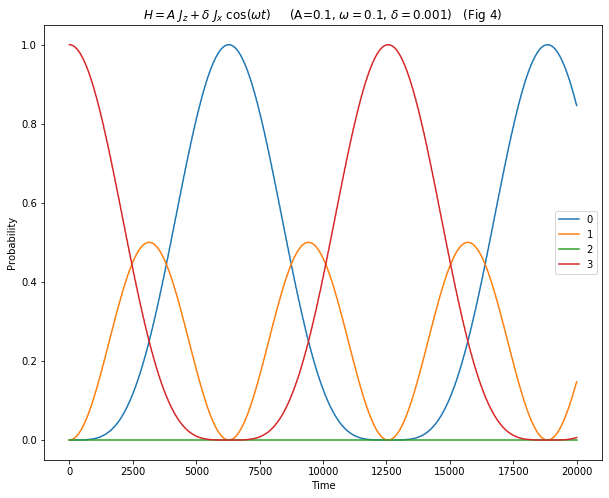

In [58]:
df.plot(figsize=(10,8), 
        title = "$H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)   (Fig 4)")
plt.xlabel("Time")
plt.ylabel("Probability");

Fig 4 shows us that the system evolves away from the highest energy level 3 and towards the lowest energy level 0 with a high chance (50%) of finding the system in a state of zero energy (level 1) part way through - nothing controversial there.

Fig 4 also shows us that energy level 2 is never occupied - this is unexpected. To understand what's going on, we need to look at the stationary states of the unperturbed system in the Dicke basis.

In [59]:
prettify_states(ekets,jm_list)

,0,1,2,3
"(1.0, 1.0)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(1.0, 0.0)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(1.0, -1.0)",1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
"(0.0, -0.0)",0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j


We can see that the stationary states of the unperturbed system are the same as the Dicke basis states i.e. the states of constant energy and constant angular momentum [share a common basis](https://ocw.mit.edu/courses/physics/8-04-quantum-physics-i-spring-2013/study-materials/MIT8_04S13_OnCommEigenbas.pdf). This is only possible if the commutator between the operators is zero - let's check.

In [1041]:
H = H0 + H1
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]
commutator(H,J2)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

The zero commutator of $J^2$ with the Hamiltonian means something more - it means that angular momentum is conserved over time, i.e. if we start in a state of a particular $j$ then we can't move to a new $j$. This explains the flat line in Fig 4. We started the simulation in energy level 3 (aka $|1, 1 \rangle$) but the system is incapable of going level 2 (aka $|0, 0 \rangle$) because it has a different angular momentum $j$.

We can confirm this by starting the system off in level 2 instead of level 3:

In [60]:
delta = 0.001
A = 0.1

H0 = A*J[2]  # Unperturbed system

H1 =  delta*J[0] # Perturbation

H_list = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

evals, ekets = H0.eigenstates()  # Find stationary states of unperturbed system

psi0 = ekets[2] 

result = sesolve(H_list, psi0, times, args={'w':A})

In [61]:
psi, P = make_p_psi_arrays(result.states, ekets) # ekets are the stationary states of H_0

In [62]:
df = pd.DataFrame(P, index=times)

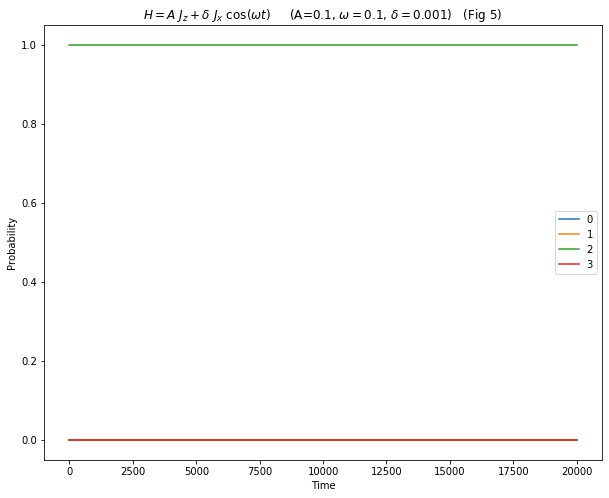

In [63]:
df.plot(figsize=(10,8), 
        title = "$H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)   (Fig 5)")
plt.xlabel("Time")
plt.ylabel("Probability");

Fig 5 shows that the system doesn't change in time. This is because there is only 1 state with $j=0$, namely |0,0> and so there is nowhere for the state to evolve to without violating the conservation of "angular momentum". 

I use quotation marks around "angular momentum" to remind us that it's not really angular momentum, but something that is mathematically equivalent. Some people call $j$ the Dicke cooperation number to remind us of this distinction.

What does the conservation of $j$ mean for the simulation of many TSS?

# Isolated $j$ universes